# Diffusion Models 101

In [1]:
from IPython.core.display import display, HTML
display(HTML("""<style>.container { width:90% !important; }.text_cell_render, .output_text {font-family: Lato;font-size: 18px;line-height: 1.5;}.CodeMirror {font-size: 16px;}</style>"""))

## About Me

I taught machine learning and distributed computing technologies at Data Science Retreat, the longest-running Berlin-based bootcamp, for more than three years, helping more than 150 students advance their careers.

My professional background includes 20 years of experience working for companies in several industries: banking, government, fintech, retail and mobility.

I write regularly for Towards Data Science. My blog post ["Understanding PyTorch with an example: a step-by-step tutorial"](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e) reached more than 300,000 views since it was published.

The positive feedback from the readers motivated me to write the series of book ["Deep Learning with PyTorch Step-by-Step: A Beginner's Guide"](https://pytorchstepbystep.com), which covers a broader range of topics.

In [2]:
#!pip install diffusers==0.16.1 accelerate open_clip_torch transformers

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage

from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np

from diffusers import DDIMScheduler, DDPMPipeline, DDIMPipeline

def plot_images(images, n=8, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, n, figsize=(10, 3))
    assert len(axs) == len(images)
    for i, img in enumerate(images):
        axs[i].axis('off')
        if isinstance(img, torch.Tensor):
            img = ToPILImage()((img/2+0.5).clamp(0, 1))
        axs[i].imshow(img.resize((64, 64), resample=Image.NEAREST), cmap='gray_r', vmin=0, vmax=255)

## Stable Diffusion

Behold the mighty stable diffusion model!

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/diffusion_model.png?raw=true)
Source: [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)

It has several moving parts, and it may look intimidating at first sight, but we'll take it apart, piece by piece, to make it more digestible.

But, before start dissecting it, let's see what it is capable of with a short example.

The example below is a slightly modified version from a [notebook](https://github.com/huggingface/diffusion-models-class/blob/main/unit3/01_stable_diffusion_introduction.ipynb) in [Unit 3 of HuggingFace's Diffusion Models class](https://github.com/huggingface/diffusion-models-class/tree/main/unit3)

In [4]:
import torch
from diffusers import DiffusionPipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/35 [00:00<?, ?it/s]

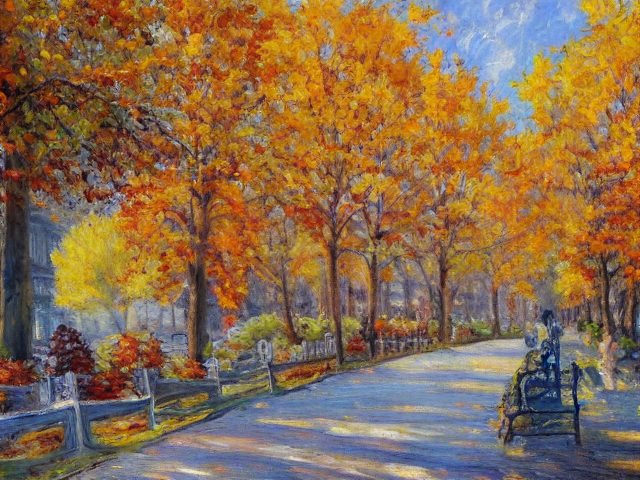

In [5]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="impressionist painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

Amazing, isn't it? Let's take a look at the several components that make up this pipeline:

In [6]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


Over the course of this session, we'll tackle or discuss most of the components above, in order:
- scheduler
- unet
- tokenizer, text encoder, and feature extractor (from CLIP)
- image encoder (VAE)

By the end of it, you should have a decent understanding and familiarity with all the above items :-)

## Agenda

Let's take a quick look at the extremely ambitious agenda for this workshop:
- Noise, Diffusion, and Schedulers
- UNet models, training loop, and HF pipelines
- Fine-tuning pretrained models/pipelines
- Generating images with simple and CLIP guidances
- Conditioning models
- Diffusion in latent space and linear diffusion

## Dataset

Diffusion models can be very large and training can be very time-consuming. For educational purposes, we'll use a dataset consisting of small images, so you can train and fine-tune models using Google Colab in a few minutes instead of a few hours, thus allowing you to experiment with different setups and configurations.

As you've probably guesses, we're using the MNIST dataset. Let's resize it from the original 28x28 pixels to 32x32 pixels, and build tensors out of the images using Torchvision transforms directly in the dataset:

In [7]:
composed = Compose([Resize(32), ToTensor()])
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=composed)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 289417633.08it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23412387.67it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 163411261.20it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19399723.80it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Let's use the `plot_images` helper function to visualize eight digits from the dataset:

In [8]:
images = next(iter(train_dataloader))[0][:8]

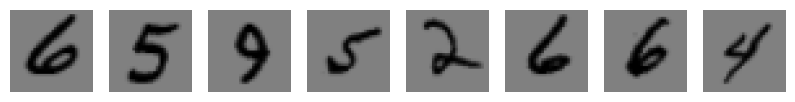

In [9]:
plot_images(images)

Typical MNIST data, nothing new to see here, let's move on!

## Noise

Let's make some noise, literally! The snippet below generates eight images of pure Gaussian noise:

In [10]:
torch.manual_seed(13)
noise = torch.randn_like(images)
noise.shape

torch.Size([8, 1, 32, 32])

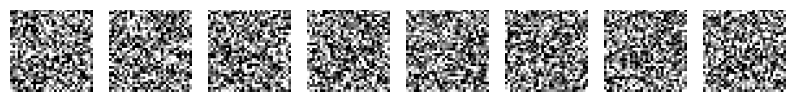

In [11]:
plot_images(noise)

Believe it or not, diffusion models are able to transform images of pure Gaussian noise into real images, like the handwritten digits of MNIST above, or fancy artwork like the first example from HF's Stable Diffusion pipeline.

I don't know about you, but I am always amazed by the thought of this incredible transformation from noise to image - it's kinda like "discovering" images inside the noise!

Let's dig a bit deeper into this process. First, let's imagine that noise is incrementally added to an image (we'll start with a blank image for now) in 1,000 small steps. Every time we take a step, we get a little bit closer to pure Gaussian noise.

In [12]:
steps = 1000
fractions = torch.linspace(0, steps-1, 5)/999
fractions

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

We can visualize this process over a few selected steps: in the beginning, the image is blank, it gets progressively noisier, until it reaches the full level of noise we generated at the start. It's like the noise is "fading in"!

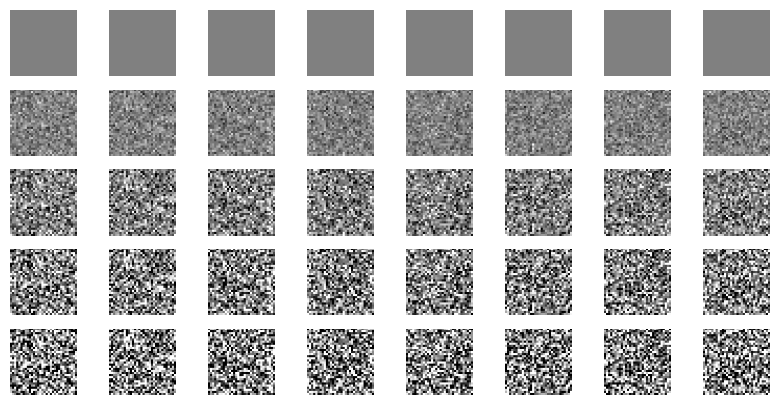

In [13]:
fig, axs = plt.subplots(len(fractions), 8, figsize=(10, 5))
for i, f in enumerate(fractions):
    plot_images(noise*f, axs=axs[i])

Now, let's do the exact opposite with the original MNIST images. We'll "fade out" the images over 1,000 steps, so they start as the original images, and they get progressively fainter, until they disappear completely into a blank image.

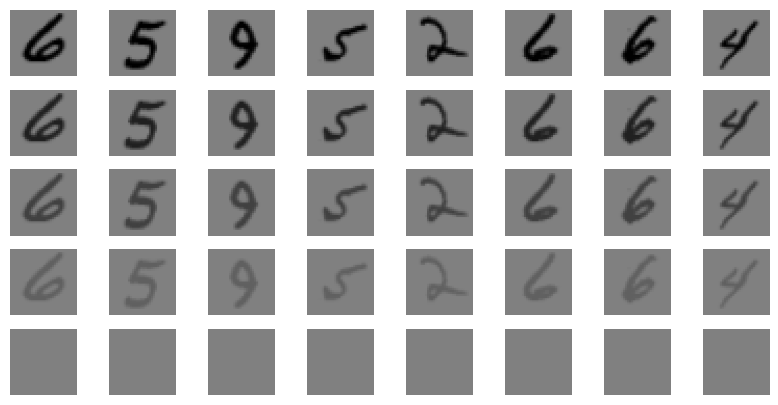

In [14]:
fig, axs = plt.subplots(len(fractions), 8, figsize=(10, 5))
for i, f in enumerate(fractions):
    plot_images((1-f)*images, axs=axs[i])

### Diffusion

Now, what happens if we add them up together, the progressively noisier images and fainter digits?

That's a simplified diffusion process!

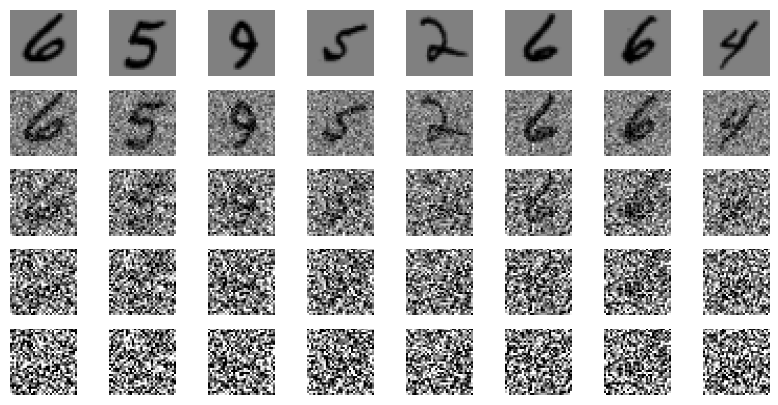

In [15]:
fig, axs = plt.subplots(len(fractions), 8, figsize=(10, 5))
for i, f in enumerate(fractions):
    plot_images(noise*f+(1-f)*images, axs=axs[i])

There is more to it than meets the eye, though: the diffusion does not have to be linear like in the example above. There are different ways to weigh images and noise, and these are called **schedules**.

Unsurprisingly, the objects that handle these schedules are called **schedulers**, the first component from the Stable Diffusion pipeline that we'll look into, and they will do all the heavy lifting for us when it comes to both **add** and **remove** (more on that later) noise to and from images.

### Scheduler

The image below, from the diffusion paper, illustrates both processes:
- adding noise to a clean image, from right to left, using `q`
- removing noise from a noisy image, from left to right, using `p`

Adding noise is pretty straightforward, and there are some nice mathematical properties that make it a breeze to know how much noise should be added as a function of the timestep you're in. We're not going into any details here, but you can check Lilian Weng's amazing [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) blog post for more details on this.

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/ddpm.png?raw=true)

Source: [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) by Jonathan Ho, Ajay Jain, Pieter Abbeel

The `diffusers` library from HuggingFace implements several schedulers, so we can leverage them to seamlessly add noise to our images. First, let's create a scheduler that uses 1,000 timesteps:

In [16]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Then, let's evenly divide the timesteps into eight parts:

In [17]:
timesteps = torch.linspace(0, noise_scheduler.config.num_train_timesteps-1, 8).long()
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999])

Next, let's use the eight images we retrieved from our dataset and, for each image, add the noise corresponding to a given timestep using the aptly named `add_noise()` method.

It takes three arguments:
- clean images
- generated noise
- timesteps

In [18]:
torch.manual_seed(13)
noise = torch.randn_like(images)

noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

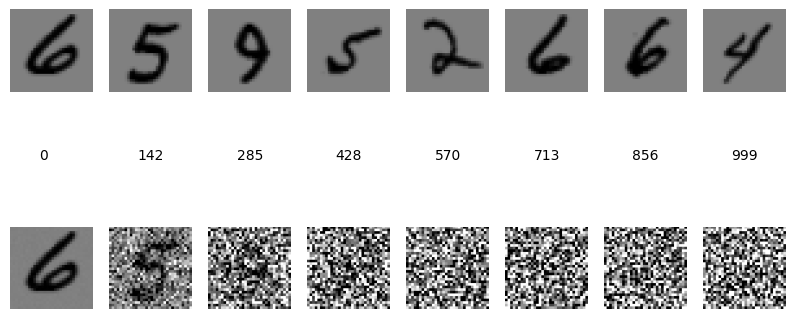

In [19]:
fig, axs = plt.subplots(3, 8, figsize=(10, 4))
plot_images(images, axs=axs[0])
plot_images(noisy_images, axs=axs[2])
for i, ax in enumerate(axs[1]):
    ax.axis('off')
    ax.text(.35, .5, str(timesteps[i].item()))

As we move from left to right, there's more and more noise added to the image. It also looks like the transition from "clean" to "noisy" image is much faster than in our example above. Why is that? It turns out, the "fading in" of the noise and the "fading out" of the original image do not follow a linear schedule.

So, I guess we're going into _some_ mathematical details after all to illustrate the process.

The expression below shows us how a given (noisy) image at timestep `t` is a composition of both the original image (`x0`) and pure Gaussian noise (`epsilon`):

$$
\Large
x_t = {\sqrt{\bar{\alpha}_t}} x_0 + \sqrt{(1 - \bar{\alpha}_t)} \epsilon
$$

They are weighted by coefficients based on the cumulative product of `alpha`. But what is this `alpha`? They are computed by the scheduler based on the defined schedule. Let's take a look at them:

In [20]:
noise_scheduler.alphas

tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9994, 0.9994, 0.9994, 0.9994,
        0.9994, 0.9993, 0.9993, 0.9993, 0.9993, 0.9993, 0.9992, 0.9992, 0.9992,
        0.9992, 0.9992, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987,
        0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9985, 0.9985, 0.9985, 0.9985,
        0.9985, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9983, 0.9983, 0.9983,
        0.9983, 0.9983, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9981, 0.9981,
        0.9981, 0.9981, 0.9981, 0.9980, 0.9980, 0.9980, 0.9980, 0.9980, 0.9979,
        0.9979, 0.9979, 0.9979, 0.9979, 0.9978, 0.9978, 0.9978, 0.9978, 0.9978,
        0.9977, 0.9977, 0.9977, 0.9977, 

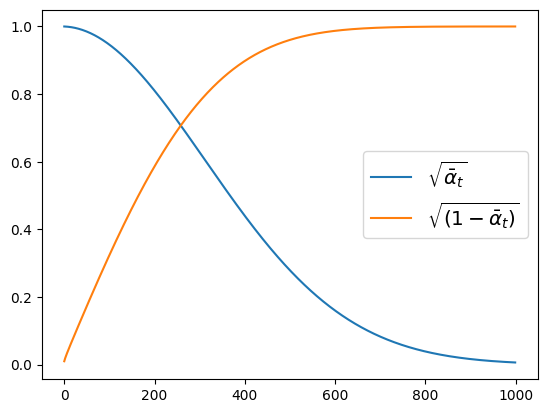

In [21]:
plt.plot(noise_scheduler.alphas_cumprod ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

The original image (`x0`) is weighted by the blue line, while the yellow line drives the noise (`epsilon`). In the beginning (`t = 0`), there's only the original image. In the end (`t = 1000`), there's only noise. You may also notice that this schedule is quite different from the naive linear schedule we used to illustrate the diffusion process.

### Reverse Diffusion

That's where the magic, or better yet, the model, happens! We know that a noisy image at a given timestep is the weighted sum of the original image and the noise:

$$
\Large
x_t = {\sqrt{\bar{\alpha}_t}} x_0 + \sqrt{(1 - \bar{\alpha}_t)} \epsilon
$$

In the diffusion process, we use two variables (the original image and the noise we create) to obtain a third (the noisy image).

In the reverse diffusion process, we have one variable (the noisy image) and we'd like to obtain another (the clean image)

$$
\Large
\hat{x_0} = \frac{\left( x_t - \sqrt{(1 - \bar{\alpha}_t)} \color{red}{\hat{\epsilon}} \right)}{\sqrt{\bar{\alpha}_t}} 
$$

But we're still missing the third variable: the noise (in red). In order to generate a clean image, we need to know the noise, but how?

What if we build a model to predict the noise?

$$
\Large
\hat{x_0} = \frac{\left( x_t - \sqrt{(1 - \bar{\alpha}_t)} \color{red}{\text{model}(x, t)} \right)}{\sqrt{\bar{\alpha}_t}}
$$

Easy enough, right? Well, in theory, yes. In practice, the model won't be *that* good to predict the right amount of noise in one shot! So, it is actually done **incrementally**: we move one step at a time, from the noisy image towards the clean image using a weighted sum of the noisy image (`xt`) and the **predicted** clean image (`^x0`).

$$
\huge
\begin{array}
&x_{t-1} &=& c_0 &\hat{x_0} &+& c_1 &x_t
\\
& =& \frac{\sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)}{1-\bar{\alpha}_t}&\hat{x_0}&+&\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t} &x_t
\end{array}
$$

As you probably expected, both coefficients are based on the `alpha` variable that drives the schedule, but we won't be going into any further details here.

#### Cheating

Now, let's "cheat" a bit here, and build a "model" that perfectly predicts the noise we're adding to the images. We're cheating because we're using this "model" as both noise generator AND predictor!

First, we use it to generate some noise, and feed the noise to the scheduler.

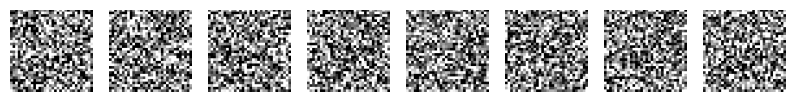

In [22]:
def model(x, t):
    torch.manual_seed(13)
    noise = torch.randn_like(x)
    return noise

noise = model(images, None)
sample = noise_scheduler.add_noise(images, noise, torch.ones(8).long()*999)
plot_images(sample)

These are noisy MNIST images and they are unrecognizable.

Then, let's use our "model" to predict epsilon, and feed it to the scheduler's `step()` method, which also takes three arguments:
- predicted noise
- timesteps
- noisy images

After calling the `step` method, we can either retrieve the noisy image at the previous (`t-1`) step using the `prev_sample` attribute or the predicted original (clean) image using the `pred_original_sample` attribute.

We *know* our model is perfect, so let's take the predicted original sample right away:

In [23]:
t = 999
epsilon = model(sample, t)
pred_x0 = noise_scheduler.step(epsilon, t, sample).pred_original_sample

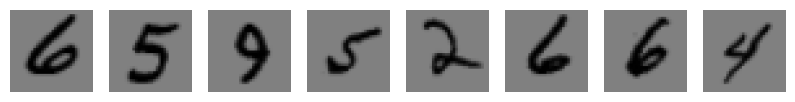

In [24]:
plot_images(pred_x0)

Perfect digits! The noise was completely removed, as expected, since we're "cheating".

#### Previous Step

Of course, perfect models do not exist. In reality, we would be iteratively generating better and better samples as we move backwards in time, using the (hopefully) less noisier sample predicted for `t-1` as input for the next step, until we reach `t = 0`.

In code, it looks like this:

In [25]:
for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        epsilon = model(sample, t)

    sample = noise_scheduler.step(epsilon, t, sample).prev_sample

It is time for a **real** model now, and the typical model used with diffusion processes is the **UNet** model.

## UNet

It is a (neural) network, and it is drawn in the shape of a "U" letter, so it is a UNet. This is the second component from the stable diffusion pipeline we introduced in the beginning.

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/hf_unit1_unet.png?raw=true)
Source: [Introduction to Diffusers - Unit 1 - HuggingFace's Diffusion Models class](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)

UNets, like the one depicted above, use a sequence of "down blocks" to reduce the dimensions of the input image (the encoder part), and then use a sequence of "up blocks" to bring the dimensions back to their full glory (the decoder part), while making residual connections between the two sequences. They were originally developed for image segmentation tasks, but they became a basic building block of diffusion models as well.

We're not going into the implementation details of the UNet, but the `diffusers` library offers an out-of-the-box fully configurable class, `UNet2DModel` that allows us to instantiate such a model that fits our needs.

In [26]:
from diffusers import UNet2DModel

image_size = 32

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=1,           # the number of input channels
    out_channels=1,          # the number of output channels
    layers_per_block=2,      # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",       # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",   # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",     # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",         # a regular ResNet upsampling block
    ),
)

How big is that?

In [27]:
model.num_parameters()/1e6

18.534017

That's 18 million parameters, not so large, so it fits well our purpose here. We'll use this model, and the scheduler, to perform a sequence of steps that belong in the training loop:

1. Fetch Clean Images
2. Generate (Full) Noise
3. Random Timesteps
4. Add Noise to Clean Images
5. Predict (Full) Noise from (Partially) Noisy Images
6. Compute Loss

First, let's create an optimizer for our model, and a loss function:

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
loss_fn = nn.MSELoss()

num_train_timesteps = noise_scheduler.config.num_train_timesteps

### Step 1: Fetch Clean Images

Nothing new here: we're loading a batch of clean images from our data loader.

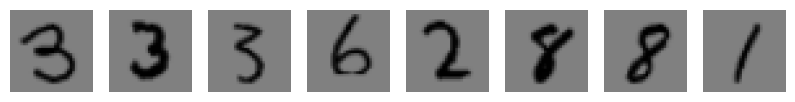

In [29]:
batch = next(iter(train_dataloader))
clean_images = batch[0].to(device)
plot_images(clean_images[:8])

### Step 2: Generate (Full) Noise

We've already done that as well: simply generating Gaussian noise in the same shape of our mini-batch of clean images.

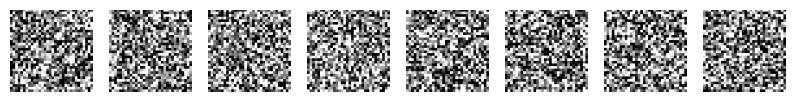

In [30]:
noise = torch.randn_like(clean_images).to(device)
plot_images(noise[:8])

### Step 3: Random Timesteps

We'd like our model to be able to handle different levels of noise added to the images (so it can perform well when we're in the reverse diffusion process predicting the image at the previous step).

Therefore, we add different amounts of noise to each image in the mini-batch by randomly choosing timesteps.

In [31]:
bs = clean_images.shape[0]
t = torch.randint(0, num_train_timesteps, (bs,), device=device).long()
t

tensor([849, 872, 676, 388, 191, 222, 645, 792, 152, 593, 201, 847, 336, 687,
        221, 885,  20, 417, 723, 714, 169, 619,  74, 854, 772, 676, 311, 922,
        225, 362, 416, 840, 498, 394, 537, 283, 823, 568, 799, 172, 597, 165,
        541, 111, 440,  93, 523, 127, 504, 245, 627, 179, 807, 936, 992, 278,
        657, 761, 204,  55, 423, 645, 830, 923], device='cuda:0')

### Step 4: Add Noise to Clean Images

We have clean images, we have Gaussian noise, and we have timesteps. It's scheduler time!

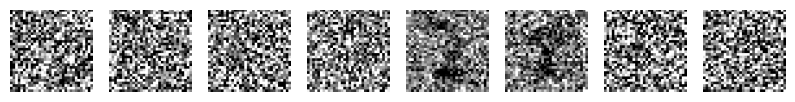

In [32]:
noisy_images = noise_scheduler.add_noise(clean_images, noise, t)
plot_images(noisy_images[:8])

### Step 5: Predict (Full) Noise from (Partially) Noisy Images

The UNet model may return a dictionary or a tuple, so we need to unpack its predictions.

Notice that the model is supposed to predict the FULL noise, even though we'll be later on trying to iteratively predict a slightly less noisier image one step at a time.

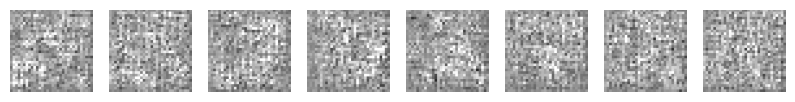

In [33]:
noise_pred = model(noisy_images, t, return_dict=False)[0]
plot_images(noise_pred[:8])

An untrained model surely produces noise as predictions, but then again, our model is supposed to predict noise! So, how can we tell if it's doing a good job? That's what loss functions are for!

### Step 6: Compute Loss

It just computes the mean squared error (MSE) between the generated and the predicted noise.

In [34]:
loss = loss_fn(noise_pred, noise)
loss

tensor(1.1268, device='cuda:0', grad_fn=<MseLossBackward0>)

There we go! We have all the diffusion-related steps (and the loss), so we're only missing the typical PyTorch training stuff (computing gradients, updating parameters, zeroing gradients) and we have ourselves a training loop.

### Training Loop

In [35]:
losses = []

for epoch in tqdm(range(10)):
    for step, batch in enumerate(train_dataloader):
        # Step 1: Fetch Clean Images
        clean_images = batch[0].to(device)

        # Step 2: Generate (Full) Noise
        noise = torch.randn_like(clean_images).to(device)

        # Step 3: Random Timesteps
        bs = clean_images.shape[0]
        t = torch.randint(0, num_train_timesteps, (bs,), device=device).long()
        
        # Step 4: Add Noise to Clean Images
        noisy_images = noise_scheduler.add_noise(clean_images, noise, t)

        # Step 5: Predict (Full) Noise from (Partially) Noisy Images
        noise_pred = model(noisy_images, t, return_dict=False)[0]

        # Step 6: Compute Loss
        loss = loss_fn(noise_pred, noise)

        # Regular PyTorch training loop stuff
        loss.backward(loss)
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

 50%|█████     | 5/10 [17:18<17:04, 204.83s/it]

Epoch:5, loss: 0.012694452354100659


100%|██████████| 10/10 [33:51<00:00, 203.11s/it]

Epoch:10, loss: 0.011291037303711306


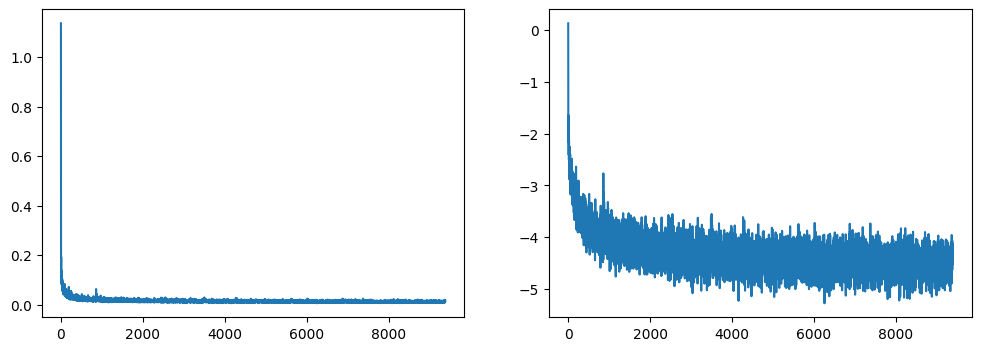

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

Training the UNet over 10 epochs in Google Colab may take 20 minutes or so. Therefore, as an alternative, I trained the model and uploaded the weights as a "release" in GitHub so you can download them.

If you train the model yourself, you should get plots for the losses like those below:

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/diffusionhf_mnist_losses.png?raw=true)

### Loading Trained Model

In [37]:
url = 'https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/releases/download/pretrained/mnist_model.pth'
state = torch.hub.load_state_dict_from_url(url, map_location=device)
model.load_state_dict(state)

Downloading: "https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/releases/download/pretrained/mnist_model.pth" to /root/.cache/torch/hub/checkpoints/mnist_model.pth
100%|██████████| 70.8M/70.8M [00:04<00:00, 15.4MB/s]


<All keys matched successfully>

### Generating Images

It is time to try to generate some MNIST digits out of pure noise!

Let's make some noise:

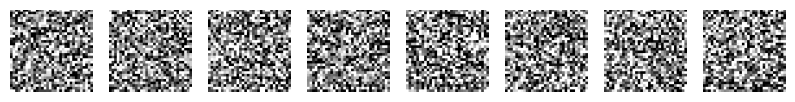

In [38]:
torch.manual_seed(37)
sample = torch.randn(8, 1, 32, 32)
plot_images(sample)

Now, let's iteratively generate less and less noisier examples using our model to predict the noise (`epsilon`) and  the scheduler's `step()` method:

In [41]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

history = []

sample = sample.to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        epsilon = model(sample, t).sample

    sample = noise_scheduler.step(epsilon, t, sample).prev_sample
    
    if not (t % 200):
        history.append(sample)

1000it [00:23, 41.75it/s]


In the plot below, we can check the progress after every 200 steps:

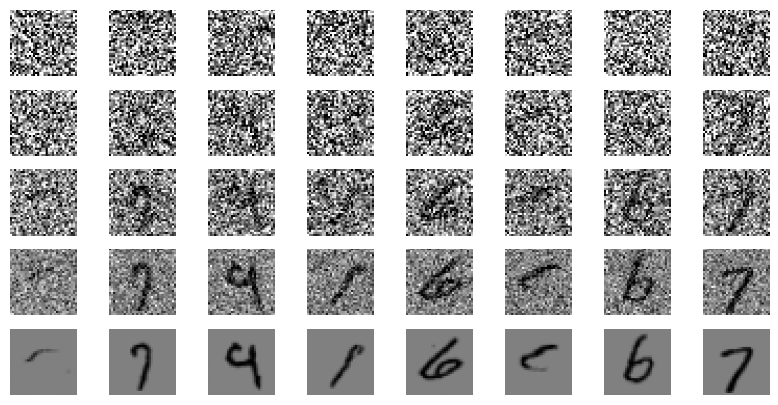

In [42]:
fig, axs = plt.subplots(len(history), 8, figsize=(10, 5))
for i, h in enumerate(history):
    plot_images(h, axs=axs[i])

That's really cool, right? I know, it's just MNIST, we're all kinda tired of that, but still, we started with noise and nothing else!

Besides, we don't even need to write a generation loop...

### DDPM Pipeline

HuggingFace has pipelines to everything, and diffusion models are no exception. We can create a `DDPMPipeline` using a trained model and the scheduler used for it, and the pipeline object does the rest:

In [43]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe(batch_size=8)

  0%|          | 0/1000 [00:00<?, ?it/s]

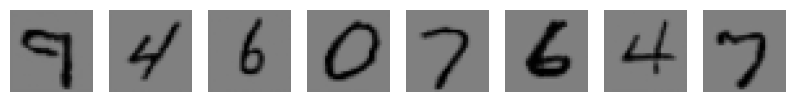

In [44]:
plot_images(pipeline_output.images)

Voilà! More MNIST digits!

### Denoising Diffusion Implicit Models (DDIM)

Perhaps you noticed it took quite a while to generate those images. No wonder, the denoising process is performed 1,000 times! Fortunately, you do not necessarily have to go through EVERY individual step to successfully turn pure noise into a meaningful image.

It was shown in the [Speeding Up Diffusion Sampling](https://minibatchai.com/diffusion/generative-models/text2image/sampling/2022/07/14/Diffusion_Sampling.html) paper that it is possible to take a shortcut and jump ahead, effectively skipping several steps at a time. For example, instead of 1,000 steps, we could use as few as 20-50 steps! The step numbers themselves, though, are unchaged - it looks like slicing a Python list.

In [45]:
torch.manual_seed(37)
sample = torch.randn(8, 1, 32, 32)

In [46]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
noise_scheduler.timesteps[::50]

tensor([999, 949, 899, 849, 799, 749, 699, 649, 599, 549, 499, 449, 399, 349,
        299, 249, 199, 149,  99,  49])

### Mixing & Matching

If you didn't buy into the idea of skipping several steps, let's try some mixing and matching ourselves to see if it works (spoiler alert: it does!).

Let's modify the generation loop a little bit:
- first, we slice the the timesteps array, so we're only taking every 50th step from it (resulting in 20 steps total)
- for each step in the sliced list, we do not take the `prev_sample` from the scheduler anymore, but the predicted denoised image (`pred_original_sample`) instead
- then, we mix it with the sample from the previous iteration, using weights proportional to how far we moved in the denoising process, to get the new, updated, noisy sample to be used in the next iteration

Notice that we're mixing it linearly for the sake of simplicity, even though our scheduler is actually following a different rule (`squaredcos_cap_v2`).

Let's see how it goes:

In [48]:
history = []

sample = sample.to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps[::50])):
    with torch.no_grad():
        epsilon = model(sample, t).sample
        
    pred_x0 = noise_scheduler.step(epsilon, t, sample).pred_original_sample
    
    mix_factor = 1 - t / noise_scheduler.config.num_train_timesteps
    sample = sample * (1 - mix_factor) + pred_x0 * mix_factor

    if not ((t+1) % 200):
        history.append(sample)

20it [00:00, 22.58it/s]


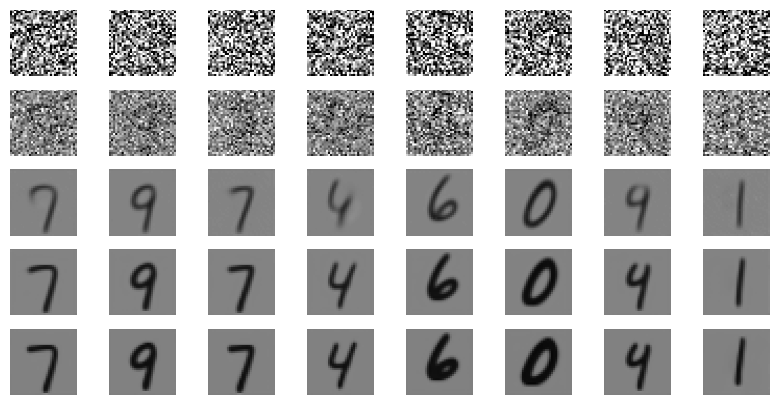

In [49]:
fig, axs = plt.subplots(len(history), 8, figsize=(10, 5))
for i, h in enumerate(history):
    plot_images(h, axs=axs[i])

Not bad, right? The digits seem a bit bold, but they are clearly recognizable as digits.

Are you convinced? I hope so. Of course, we won't be mixing anything manually, we can simply use the appropriate scheduler and pipeline classes for that: `DDIMScheduler` and `DDIMPipeline`.

We may even "convert" our former DDPM scheduler into a new DDIM scheduler by calling the `from_config()` method available to all schedulers:

In [50]:
from diffusers import DDIMPipeline, DDIMScheduler

new_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
new_image_pipe = DDIMPipeline(unet=model, scheduler=new_scheduler)

Let's put our new pipeline to the test:

In [51]:
pipeline_output = new_image_pipe(batch_size=8, num_inference_steps=20)

  0%|          | 0/20 [00:00<?, ?it/s]

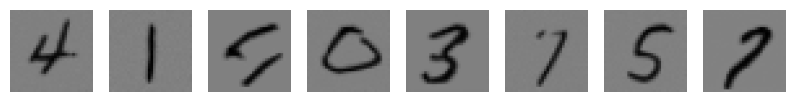

In [52]:
plot_images(pipeline_output.images)

Hooray! That was much faster! Misson acomplished!

## Fine-Tuning

It is 2023 and barely anyone trains deep learning models from scratch anymore. Everyone fine-tunes an existing pretrained model so it fits their own purposes instead. 

Let's take a pretrained pipeline, Google's `ddpm-cifar10-32`, a diffusion model trained on the CIFAR10 dataset, and fine-tune it on our own MNIST digits.

### Loading Pretrained Pipeline

Let's load the pretrained pipeline directly from the HuggingFace Hub:

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
image_pipe.to(device)

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.16.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [54]:
image_pipe.unet.num_parameters()/1e6

35.746307

Then, let's use it to generate some images, so we know what we're dealing with here:

In [55]:
images = image_pipe(batch_size=8).images

  0%|          | 0/1000 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:115 in decorate_context       │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/ddpm/pipeline_ddpm.py:92 in __call__ │
│                                                                                                  │
│    89 │   │                                                                                      │
│    90 │   │   for t in self.progress_bar(self.scheduler.timesteps):                              │
│    91 │   │   │   # 1. predict noise model_output                                                │
│ ❱  92 │   │   │   model_output = self.unet(image, t).sample                                      │
│    93 │   │   │                                                                                  │
│    94 │   │   │   # 2. compute previous image: x_t -> x_t-1                                      │
│    95 │   │   │   image = self.scheduler.step(model_output, t, image, generator=generator).pre   │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/models/unet_2d.py:283 in forward               │
│                                                                                                  │
│   280 │   │   │   │   │   hidden_states=sample, temb=emb, skip_sample=skip_sample                │
│   281 │   │   │   │   )                                                                          │
│   282 │   │   │   else:                                                                          │
│ ❱ 283 │   │   │   │   sample, res_samples = downsample_block(hidden_states=sample, temb=emb)     │
│   284 │   │   │                                            

Wait, stop!

Who has the time to wait for the DDPM scheduler to generate images?!

Let's create a much faster DDIM scheduler and assign it to the pipeline instead:

In [56]:
scheduler = DDIMScheduler.from_pretrained('google/ddpm-cifar10-32')
image_pipe.scheduler = scheduler

In [57]:
images = image_pipe(batch_size=8, num_inference_steps=40).images

  0%|          | 0/40 [00:00<?, ?it/s]

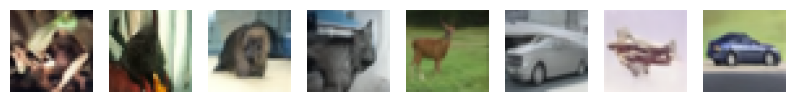

In [58]:
plot_images(images)

They are indeed CIFAR-ish, as expected. Notice that, unlike MNIST images, they are colored RGB images. Therefore, we need to adjust our own images to the pipeline's expected input: 3-channel 32x32 pixel images. We can use Torchvision's Lambda transform to replicate MNIST's single channel three times.

In [59]:
from torchvision.transforms import Lambda

composed = Compose([Resize(32), ToTensor(), Lambda(lambda x: x.repeat(3, 1, 1))])
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=composed)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [60]:
images = next(iter(train_dataloader))[0][:8]

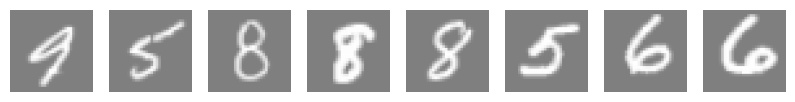

In [61]:
plot_images(images)

### Training Loop

The training loop is essentially the same as the one we used to train a model from scratch. There are a few small differences, since we're using both scheduler and model directly from the pipeline, `pipeline.scheduler` and `pipeline.unet`, respectively.

It goes over the same steps (1-6) and typical PyTorch training stuff (computing gradients, updating parameters, zeroing gradients).

This code was adapted from [Unit 2 of HuggingFace's Diffusion Models class](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/01_finetuning_and_guidance.ipynb)

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sending pipeline to device
image_pipe.to(device)
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

# Fetching scheduler from the pipeline
num_train_timesteps = image_pipe.scheduler.config.num_train_timesteps

In [63]:
losses = []

for epoch in tqdm(range(3)):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        # Step 1: Fetch Clean Images
        clean_images = batch[0].to(device)

        # Step 2: Generate (Full) Noise
        noise = torch.randn_like(clean_images).to(device)

        # Step 3: Random Timesteps
        bs = clean_images.shape[0]
        t = torch.randint(0, num_train_timesteps, (bs,), device=device).long()
        
        # Step 4: Add Noise to Clean Images
        # Fetching scheduler from the pipeline
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, t)

        # Step 5: Predict (Full) Noise from (Partially) Noisy Images
        # Fetching model from the pipeline
        noise_pred = image_pipe.unet(noisy_images, t, return_dict=False)[0]

        # Step 6: Compute Loss
        loss = loss_fn(noise_pred, noise)

        # Regular PyTorch training loop stuff
        loss.backward(loss)
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

 33%|███▎      | 1/3 [07:23<14:47, 443.98s/it]

Epoch:1, loss: 0.009883817065376114



 67%|██████▋   | 2/3 [14:47<07:23, 443.92s/it]

Epoch:2, loss: 0.010047375786501462



100%|██████████| 3/3 [22:12<00:00, 444.03s/it]

Epoch:3, loss: 0.009895785696316026


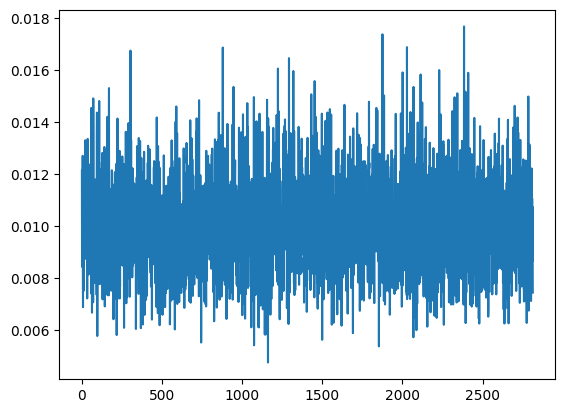

In [64]:
plt.plot(losses)

Given the size of the model, it may take ~20 minutes to fine-tune it on Google Colab. Instead, we'll be loading the fine-tuned model in a couple of sections.

But, if you're running it and waiting for it to finish, you should expect to see losses like this:

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/diffusion_finetuning_mnist_losses.png?raw=true)

### Pushing to Hub

You don't need to run these cells - I've kept them here so you can get the hang of pushing a fine-tuned pipeline to HuggingFace's Hub, in case you'd like to share it with others, as I did.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import HfApi, create_repo

hub_model_id = "dvgodoy/ddpm-cifar10-32-mnist"
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="ddpm-cifar10-32-mnist/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="ddpm-cifar10-32-mnist/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="ddpm-cifar10-32-mnist/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

diffusion_pytorch_model.bin:   0%|          | 0.00/143M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

'https://huggingface.co/dvgodoy/ddpm-cifar10-32-mnist/blob/main/model_index.json'

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Diffusion Models 101

This model is a diffusion model for unconditional image generation of MNIST digits fine-tuned on Google's ddpm-cifar10-32 model

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/dvgodoy/ddpm-cifar10-32-mnist/blob/main/README.md'

### Loading From Hub

Once the model is pushed to the Hub, you can load it like any other model from there. 

In the interest of time, let's just load the resulting model and pipeline instead of running the training loop above.

In [65]:
from diffusers import DDPMPipeline, DDIMScheduler
image_pipe = DDPMPipeline.from_pretrained('dvgodoy/ddpm-cifar10-32-mnist')

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Then we can generate images in the usual way:

In [67]:
image_pipe.to(device)
images = image_pipe(batch_size=8, num_inference_steps=40).images

  0%|          | 0/40 [00:00<?, ?it/s]

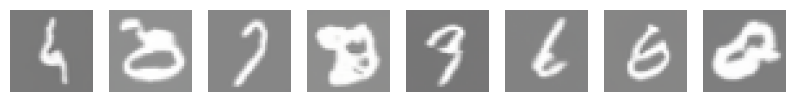

In [68]:
plot_images(images)

On the up side, these images are not CIFAR-ish at all! On the down side, they do not quite look like MNIST digits yet...

Well, it actually depends on whom you ask :-)

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/paracetamol.png?raw=true)

### Generating Images

Please bear with me as we bring back the manual loop for image generation. You'll see why we're doing this very very shortly. Just like in the training loop, we're taking both scheduler and model directly from the pipeline.

In [70]:
noise_scheduler = image_pipe.scheduler
model = image_pipe.unet

torch.manual_seed(33)
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # Ensures schedulers are interchangeable
    model_input = noise_scheduler.scale_model_input(sample, t)
    
    with torch.no_grad():
        epsilon = model(sample, t).sample
        
    sample = noise_scheduler.step(epsilon, t, sample).prev_sample

40it [00:01, 26.66it/s]


Then, let's generate some images as sanity check:

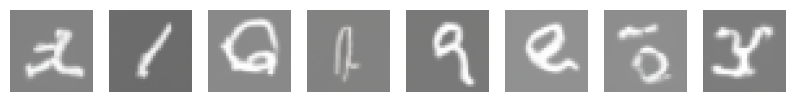

In [71]:
plot_images(sample)

Cool, they still look like handwritten digits from a doctor :-)

Or, perhaps, they look like falling characters from "The Matrix"?

## Guidance

What if we wanted our digits to be green as the falling characters from "The Matrix"? They kinda look like that already, so why not?

The question is, how can we tell the model we like our digits green? 

We need to guide our model into the right path or, as Morpheus said to Neo, "there's a difference between knowing the path, and walking the path." 

Deep, right?

### Color

We start defining the color of "The Matrix", and generating a single pixel colored like that, expanded to the expected four dimensions of a PyTorch mini-batch of images: NCHW.

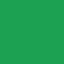

In [72]:
# The Matrix
color = (28/255, 161/255, 82/255)

colored_pixel = torch.tensor(color)[None, :, None, None]
colored_pixel, colored_pixel.shape # NCHW
ToPILImage()(colored_pixel[0]).resize((64, 64))

That's green for sure! Now, let's center its values at zero:

In [73]:
colored_pixel = colored_pixel * 2 - 1
colored_pixel

tensor([[[[-0.7804]],

         [[ 0.2627]],

         [[-0.3569]]]])

#### Color Loss

Once our guiding pixel is on the same footing as our noisy samples, we can take the mean absolute difference between them. We only have ONE green pixel to compare the other image to, but broadcasting has our backs, so it will effectively compare that lone pixel to every other pixel.

In [75]:
# Mean pixel difference between an image and our (broadcast) colored pixel
torch.abs(sample[0] - colored_pixel.to(device)).mean()

tensor(0.5641, device='cuda:0')

Let's organize this code into a function that takes a mini-batch of images and returns the corresponding loss:

In [76]:
def color_loss(images, color):
    colored_pixel = torch.tensor(color).to(images.device)[None, :, None, None]
    colored_pixel = colored_pixel * 2 - 1
    errors = torch.abs(images - colored_pixel)
    loss = errors.mean()
    return loss

In [77]:
color_loss(sample, color)

tensor(0.5547, device='cuda:0')

That's a loss value, but aren't you **missing** anything?

We usually call the `backward()` method on losses, but it only makes sense to do so if the loss itself is gradient-requiring tensor, right? Let's fix that by **making our samples require gradient**.

In [78]:
sample_with_grad = sample.detach().requires_grad_()
loss = color_loss(sample_with_grad, color)
loss

tensor(0.5547, device='cuda:0', grad_fn=<MeanBackward0>)

Just like we update parameters using their gradients (based on the MSE loss, for example) and a learning rate, we'll update samples using their gradients (based on the color loss we used as guidance) and a learning rate-equivalent called `guidance_loss_scale`.

In [79]:
guidance_loss_scale = 40

grad = torch.autograd.grad(loss, sample_with_grad)[0]

sample = sample_with_grad.detach()
sample = sample - guidance_loss_scale * grad  # analogous to w = w - lr * grad

Notice that we're detaching the sample (i.e. removing the gradient requirement) because it will be an input to the scheduler's `step()` method.

Moreover, we will be computing the loss by comparing the **predicted denoised image**, the image we're actually interested in, and the one that we'd like to be green, to the guiding green pixel.

### Generating Images

Let's update our generation loop to include all the steps from the guidance code:
1. making samples gradient-requiring
2. compute the color loss between the predicted denoised image and the guiding color
3. computes gradients of the color loss w.r.t. to the image's pixels
4. detach the samples and update them using the gradients and the guidance loss scale (the "learning rate")

Other than that, the following code also includes a call to the scheduler's `scale_model_input()` method that ensures that schedulers are interchangeable (this was copied from the pipeline's generation method, but it has no impact in this example).

In [80]:
noise_scheduler = image_pipe.scheduler
model = image_pipe.unet

torch.manual_seed(33)
sample = torch.randn(8, 3, 32, 32).to(device)
guidance_loss_scale = 40

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # Ensures schedulers are interchangeable
    model_input = noise_scheduler.scale_model_input(sample, t)
    
    with torch.no_grad():
        epsilon = model(sample, t).sample
        
    ## GUIDANCE ##
    # Step 1
    sample_with_grad = sample.detach().requires_grad_()
    
    # Step 2
    # What does the denoised image look like at this point?
    pred_x0 = noise_scheduler.step(epsilon, t, sample_with_grad).pred_original_sample
    # Does it have the right color?
    loss = color_loss(pred_x0, color)
    if i % 10 == 0:
        print(i, "loss:", loss.item())
    
    # Step 3
    # Compute gradient
    grad = torch.autograd.grad(loss, sample_with_grad)[0]
    
    # Step 4
    # Detach the sample so it is a regular tensor again
    sample = sample_with_grad.detach()
    # Update the sample
    sample = sample - guidance_loss_scale * grad
    ##############

    # Uses the updated sample in the next step    
    sample = noise_scheduler.step(epsilon, t, sample).prev_sample

5it [00:00, 20.40it/s]

0 loss: 0.6179776191711426


16it [00:00, 29.08it/s]

10 loss: 0.21107158064842224


24it [00:00, 30.98it/s]

20 loss: 0.2123003453016281


36it [00:01, 31.93it/s]

30 loss: 0.24464568495750427


40it [00:01, 29.78it/s]


What the resulting images look like?

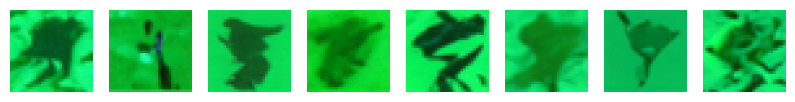

In [81]:
plot_images(sample)

WOW! They are definitely green like "The Matrix", so we definitely guided them well into being green. But they apparently got lost in the digits department. The generation process got biased towards complying with the guidance, at the expense of the underlying task: generating digits.

You can try adjusting the `guidance_loss_scale` variable to see if you can make them more digit-ish and less green.

But there's also a different way of incorporating the guidance into the generation loop: gradients all the way!

We're moving Step 1 to the very top, making samples gradient-requiring from the get go, and ditching the `no_grad()` context manager altogether. 

Notice that the loss is computed using `pred_x0`, which is computed using the sample that is requiring gradients now. This means that the denoising process itself is part of the dynamic computation graph now, thus affecting the gradients used to update the sample in the guidance process.

In [82]:
noise_scheduler = image_pipe.scheduler
model = image_pipe.unet

torch.manual_seed(33)
sample = torch.randn(8, 3, 32, 32).to(device)
guidance_loss_scale = 150

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # Step 1
    sample_with_grad = sample.detach().requires_grad_()

    # Ensures schedulers are interchangeable
    model_input = noise_scheduler.scale_model_input(sample_with_grad, t)
    
    # with torch.no_grad():
    epsilon = model(sample_with_grad, t).sample
        
    ## GUIDANCE ##
    # Step 2
    # What does the denoised image look like at this point?
    pred_x0 = noise_scheduler.step(epsilon, t, sample_with_grad).pred_original_sample
    
    # Does it have the right color?
    loss = color_loss(pred_x0, color)
    if i % 10 == 0:
        print(i, "loss:", loss.item())
    
    # Step 3
    # Compute gradient
    grad = torch.autograd.grad(loss, sample_with_grad)[0]
    
    # Step 4
    # Detach the sample so it is a regular tensor again
    sample = sample_with_grad.detach()
    # Update the sample
    sample = sample - guidance_loss_scale * grad

    # Uses the updated sample in the next step    
    sample = noise_scheduler.step(epsilon, t, sample).prev_sample

2it [00:00, 10.76it/s]

0 loss: 0.6179782152175903


12it [00:00, 13.39it/s]

10 loss: 0.5000095367431641


22it [00:01, 13.34it/s]

20 loss: 0.44515037536621094


32it [00:02, 13.35it/s]

30 loss: 0.4015977382659912


40it [00:03, 13.24it/s]


Let's take a look at the images:

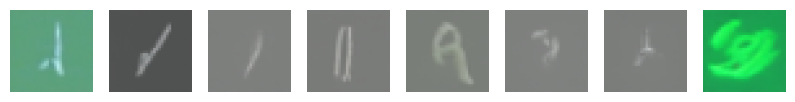

In [83]:
plot_images(sample)

They are more digit-ish now, that's for sure, and some of them are green-ish. Again, you can try tweaking the `guidance_loss_scale` to try generating more-balanced images.

But let's be honest, turning images green isn't that impressive, and it's also quite some work since we had to define a custom loss function just for that.

What if we could use words to guide our model instead?

## CLIP

CLIP is awesome! It is the bridge between the worlds of images and text. It was trained on captioned images, so it knows the right association between a word and the image it represents. This means that, if we get CLIP embeddings for a word, let's say "duck", and we also get CLIP embeddings for an image of a duck, the embeddings should be "close" to each other in the embedding space.

***
For more details about CLIP, check its OpenAI page: [CLIP: Connecting text and images](https://openai.com/research/clip).
***

We can use this distance between the two embeddings as loss. If it looks like a duck, and it is called a duck, the distance between the two is low, so is the loss. If it looks like a duck, but it is being called a horse, the distance between the two is high, and so is the loss.

In truth, it's a bit more complicated than that: we compute the norm of both vectors, and take the squared great circle distance between them.

In [84]:
# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image_features, text_features):
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    # Squared Great Circle Distance
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    return dists.mean()

Let's load one pretrained CLIP model:

In [85]:
import open_clip

device = 'cuda' if torch.cuda.is_available() else 'cpu'

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device)

100%|███████████████████████████████████████| 354M/354M [00:04<00:00, 79.8MiB/s]


CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-

Each model has a set of prescribed transformations that should be applied to the input images, so they match the preprocessing steps executed during pretraining:

In [86]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7fa0eec4cb80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

So, let's apply CLIP's transformations to our MNIST dataset:

In [87]:
new_dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=preprocess)
new_dataloader = DataLoader(new_dataset, batch_size=64, shuffle=True)

What our preprocessed images look like now?

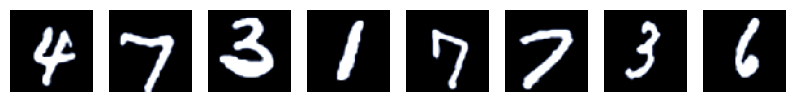

In [88]:
images, labels = next(iter(new_dataloader))
plot_images(images[:8])

The CLIP model implements an `encode_image()` method that returns the corresponding embeddings to an image, as discussed before:

In [89]:
with torch.no_grad():
    image_features = clip_model.encode_image(images.to(device))
image_features.shape

torch.Size([64, 512])

This particular CLIP model returns 512-dimension embeddings.

What about the words? As usual, it starts with the tokenization.

In our example, we'll use as "prompts" the short sentences "handwritten digit zero", "handwritten digit one", and so on. We can use the `tokenize()` method of the `open_clip` package to tokenize these prompts.

In [90]:
prompts = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
prompts = [f'handwritten digit {p}' for p in prompts]
text = open_clip.tokenize(prompts).to(device)
text[0]

tensor([49406, 35192, 27472,  5848, 49407,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')

Once the sentences are properly tokenized, we can retrieve their corresponding embeddings using the model's `encode_text()` method:

In [91]:
with torch.no_grad():
    text_features = clip_model.encode_text(text)
text_features.shape

torch.Size([10, 512])

Ten prompts, 512-dimension embeddings.

Now, let's compute the distances (losses) between the images in a mini-batch and all these prompts:

In [92]:
distances = np.array([[clip_loss(img.unsqueeze(0), text.unsqueeze(0)).item() for text in text_features] for img in image_features])
distances.shape

(64, 10)

For each one of the 64 images in our mini-batch, there are 10 computed distances, one for each prompt. Ideally, the shortest distance should match the image's label. But, does it?

In [93]:
np.argmin(distances, axis=1), labels

(array([3, 7, 3, 8, 7, 3, 3, 8, 0, 7, 3, 7, 8, 0, 0, 0, 8, 0, 8, 3, 2, 8,
        7, 8, 8, 7, 3, 3, 0, 0, 3, 8, 2, 0, 3, 0, 3, 8, 3, 7, 8, 8, 3, 0,
        8, 8, 0, 3, 0, 8, 3, 8, 8, 8, 3, 3, 8, 0, 8, 0, 8, 3, 3, 0]),
 tensor([4, 7, 3, 1, 7, 7, 3, 6, 0, 5, 3, 9, 3, 0, 2, 0, 8, 1, 6, 3, 2, 6, 5, 9,
         6, 8, 8, 9, 0, 1, 2, 9, 7, 6, 5, 2, 9, 1, 4, 3, 9, 1, 3, 4, 6, 6, 4, 3,
         6, 9, 3, 2, 6, 9, 3, 9, 8, 2, 6, 0, 6, 2, 6, 0]))

In [94]:
(np.argmin(distances, axis=1) == labels.numpy()).sum()/len(labels)

0.296875

Better than chance, that's for sure, but not impressive. It seems to match 8s and 3s more easily.

By the way, CLIP's tokenizer, text encoder, and image encoder (aka feature extractor) are the third component of the stable difussion pipeline introduced at the beginning.

### CLIP Guidance

Before we jump into guidance with CLIP, we need to make some small adjustments to the preprocessing steps. It assumes its inputs would be PIL images, but we're actually feeding it the predicted denoised image produced by the scheduler, which is already a tensor.

In [95]:
preprocess.transforms = preprocess.transforms[:2] + preprocess.transforms[4:]

In [96]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

Let's load our fine-tuned pipeline and retrieve its scheduler and model:

In [101]:
#image_pipe = DDPMPipeline.from_pretrained('ddpm-cifar10-32-mnist/', local_files_only=True)
image_pipe = DDPMPipeline.from_pretrained('dvgodoy/ddpm-cifar10-32-mnist')
image_pipe.to(device)
noise_scheduler = image_pipe.scheduler
noise_scheduler.set_timesteps(50)
model = image_pipe.unet

diffusion_pytorch_model.safetensors not found


We're bringing back the first kind of generating loop with guidance, the kind that keeps the denoising process out of the computation graph, for the sake of speed.

Even so, there are still a few differences between CLIP guidance, and our first color guidance.
- First, we're actually looping over the sample generation `n_cuts` times to average gradients over multiple candidates for denoised image;
- Second, we preprocess the predicted denoised images so they are proper inputs for retrieving CLIP embeddings;
- Third, we tokenize and encode (i.e. retrieve embeddings) of the prompt we're using to guide the generation - "handwritten digit seven" in the example below.

In [102]:
torch.manual_seed(33)
sample = torch.randn(8, 3, 32, 32).to(device)
guidance_loss_scale = 200
n_cuts = 2

prompt = 'handwritten digit seven'
text = open_clip.tokenize(prompt).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # Ensures schedulers are interchangeable
    model_input = noise_scheduler.scale_model_input(sample, t)
    
    with torch.no_grad():
        epsilon = model(sample, t).sample
        
    ## GUIDANCE ##
    grad = 0
    for j in range(n_cuts):
        # Step 1
        sample_with_grad = sample.detach().requires_grad_()
        
        # Step 2
        # What does the denoised image look like at this point?
        pred_x0 = noise_scheduler.step(epsilon, t, sample_with_grad).pred_original_sample
        # CLIP
        # pred_x0 is in the [-1, 1] range, so we make it [0, 1] before preprocessing it
        preproc_x0 = preprocess(pred_x0/2+0.5)
        image_features = clip_model.encode_image(preproc_x0)
        loss = clip_loss(image_features, text_features)

        # Step 3
        # Compute gradient
        grad += torch.autograd.grad(loss, sample_with_grad)[0] / n_cuts

    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Step 4
    # Detach the sample so it is a regular tensor again
    sample = sample_with_grad.detach()
    # Update the sample
    alpha = noise_scheduler.alphas_cumprod[i].sqrt()
    sample = sample - alpha * guidance_loss_scale * grad
    ##############

    # Uses the updated sample in the next step    
    sample = noise_scheduler.step(epsilon, t, sample).prev_sample

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
1it [00:00,  4.12it/s]

0 loss: 0.9021048545837402


11it [00:02,  5.06it/s]

10 loss: 0.8777129650115967


21it [00:04,  4.68it/s]

20 loss: 0.7668953537940979


32it [00:06,  6.10it/s]

30 loss: 0.7206590175628662


42it [00:07,  6.85it/s]

40 loss: 0.6571564674377441


50it [00:08,  5.65it/s]


We'd like to see some images resembling a handwritten seven, so let's check them out:

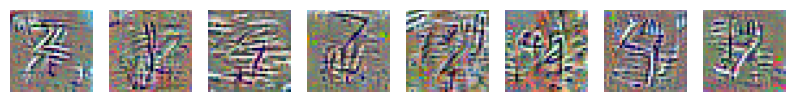

In [103]:
plot_images(sample)

Well, maybe if you squint your eyes a bit, you'll see something that's seven... adjacent?

Jokes aside, our models are far from state-of-the-art, so these results aren't totally unexpected. Our fine-tune `ddpm-cifar10-32-mnist` generated barely recognizable digits in the first place. Still, it is good enough to illustrate the inner mechanics of the CLIP-guided generation process.

Moreover, if you didn't notice, there was yet another multiplying factor (`alpha`) in the sample update. This factor comes from the schedule configured for the scheduler, and there are several possible guidance scaling schedules (the one used above is `alpha_bar.sqrt()` in the figure below:

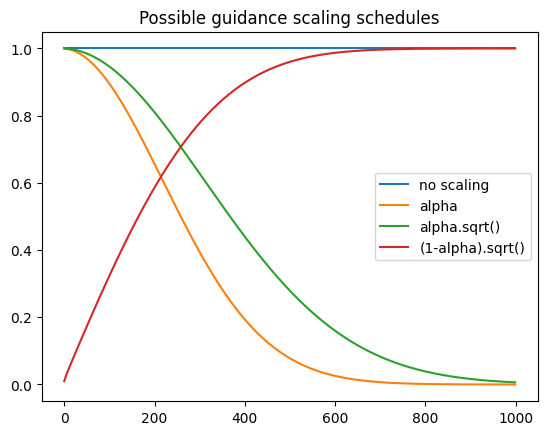

In [104]:
plt.plot([1 for a in noise_scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in noise_scheduler.alphas_cumprod], label="alpha")
plt.plot([a.sqrt() for a in noise_scheduler.alphas_cumprod], label="alpha.sqrt()")
plt.plot(
    [(1 - a).sqrt() for a in noise_scheduler.alphas_cumprod], label="(1-alpha).sqrt()"
)
plt.legend()
plt.title("Possible guidance scaling schedules");

Guidance is cool and all, but it seems a lot of work, and it seems hard to handle. Wouldn't it be so much better if the model was already trained to listen to our requests or, better yet, our conditions?

## Conditioning

We can create conditioned models by embedding the labels (classes) as channels in the input images. We will go over this in detail in the next subsection.

First, as it is typical by now, we need to reload our MNIST dataset using the appropriate transformations:

In [105]:
composed = Compose([Resize(32), ToTensor()])
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=composed)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
images, labels = next(iter(train_dataloader))

### Class Embeddings as Channels

According to the transformations above, our images will be 32x32 pixels in size, and since we're dealing with MNIST digits, there are 10 classes in total.

We'd like to transform these labels/classes into embeddings, so we need to choose an embedding size. Remember, though, that we're stacking these embeddings as "channels" on top of our original input image. So, let's pick a reasonable embedding size: four, so there will be four more "channels", to a total of five.

In [106]:
image_size = 32
num_classes = 10
emb_size = 4
class_emb = nn.Embedding(num_classes, emb_size)
class_emb

Embedding(10, 4)

If we retrieve the (untrained) embeddings for a mini-batch of labels, we'll get the expected output shape:

In [107]:
embeddings = class_emb(labels)
embeddings.shape

torch.Size([64, 4])

Now comes the tricky dimension expansion: each value in the embedding array must become a full 32x32 channel. The value will be replicated, and every "pixel" in the corresponding extra channel will have the very same value.

In [108]:
embeddings = embeddings.view(*embeddings.shape, 1, 1).expand(*embeddings.shape, image_size, image_size)
embeddings.shape

torch.Size([64, 4, 32, 32])

The original mini-batch of images, as expected, has single-channel 32x32 pixel images:

In [109]:
images.shape

torch.Size([64, 1, 32, 32])

The shapes match, we can stack them up over the second dimension:

In [110]:
concatenated = torch.cat((images, embeddings), 1)
concatenated.shape

torch.Size([64, 5, 32, 32])

In [ ]:
labels[0], cla_emb(labels[1:]), concatenated[0, 1, :, :]

Now, we have to do exactly that in the `forward()` method of our conditioned model!

### Conditioned Model

The conditioned model is a wrapper around the original UNet model we have already used, with a few differences:
- we create an embedding layer to map our classes into embeddings;
- the number of input channels in the UNet model must match the total number of stacked channels (one from the original images, four from the class embeddings);
- the `forward()` method retrieves the embeddings, expands their dimensions, and stacks them together with the original inputs to pass it as arguments to the underlying UNet model.

In [111]:
from diffusers import UNet2DModel

class ClassConditionedUnet(nn.Module):
    def __init__(self, image_size, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=image_size,           # the target image resolution
            in_channels=1 + class_emb_size, # Additional input channels for class cond.
            out_channels=1,           # the number of output channels
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(64, 128, 128, 256), 
            down_block_types=(
                "DownBlock2D",       # a regular ResNet downsampling block
                "DownBlock2D",
                "AttnDownBlock2D",   # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",     # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",
                "UpBlock2D",         # a regular ResNet upsampling block
            ),
        )

  # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, labels):
        # Shape of x:
        bs, ch, w, h = x.shape
        
        embeddings = self.class_emb(labels)
        embeddings = embeddings.view(*embeddings.shape, 1, 1).expand(*embeddings.shape, w, h)
        # x is shape (bs, 1, img_size, img_size) and class_cond is now (bs, 4, img_size, img_size)

        # Net input is now x and class cond concatenated together along dimension 1
        concatenated = torch.cat((x, embeddings), 1)

        # Feed this to the unet alongside the timestep and return the prediction
        return self.model(concatenated, t).sample # (bs, 1, img_size, img_size)

### Training Loop

This time, the training loop is just business as usual, nothing to see here.

In [112]:
from diffusers import DDPMScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ClassConditionedUnet(image_size=32)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
num_train_timesteps = noise_scheduler.config.num_train_timesteps

In [113]:
losses = []

for epoch in tqdm(range(10)):
    for step, batch in enumerate(train_dataloader):
        # Step 1: Fetch Clean Images
        clean_images = batch[0].to(device)
        clean_labels = batch[1].to(device)

        # Step 2: Generate (Full) Noise
        noise = torch.randn_like(clean_images).to(device)

        # Step 3: Random Timesteps
        bs = clean_images.shape[0]
        t = torch.randint(0, num_train_timesteps, (bs,), device=device).long()
        
        # Step 4: Add Noise to Clean Images
        noisy_images = noise_scheduler.add_noise(clean_images, noise, t)

        # Step 5: Predict (Full) Noise from (Partially) Noisy Images
        noise_pred = model(noisy_images, t, clean_labels)

        # Step 6: Compute Loss
        loss = loss_fn(noise_pred, noise)

        # Regular PyTorch training loop stuff
        loss.backward(loss)
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

 50%|█████     | 5/10 [17:00<16:58, 203.68s/it]

Epoch:5, loss: 0.012705898293153023


100%|██████████| 10/10 [33:55<00:00, 203.58s/it]

Epoch:10, loss: 0.011085031487579857


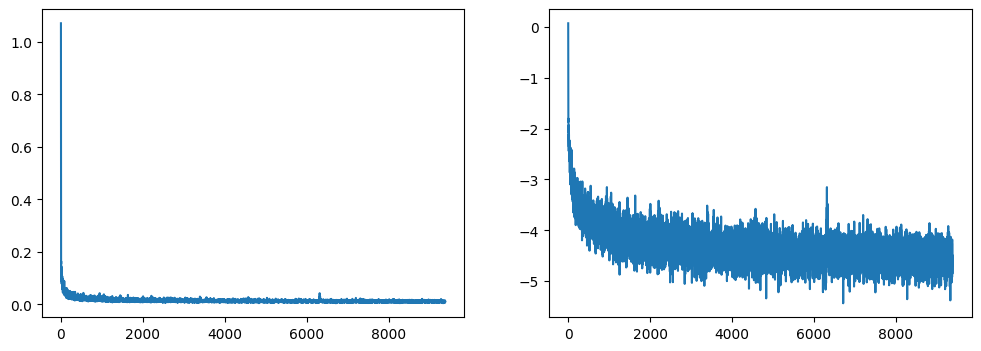

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

This model takes quite some time to be trained on Google Colab (~30 min), so we'll be loading a checkpoint instead. If you do run it yourself, you'll see losses like those depicted below:

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/diffusionhf_cond_mnist_losses.png?raw=true)

### Loading Trained Model

The checkpoint is more than 70 Mb in size, so I stored it as a release asset in the repo of this workshop. You can load it using Torch Hub's `state_dict_from_url()` method:

In [115]:
url = 'https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/releases/download/pretrained/mnist_conditional_model.pth'
state = torch.hub.load_state_dict_from_url(url, map_location=device)
model.load_state_dict(state)

Downloading: "https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/releases/download/pretrained/mnist_conditional_model.pth" to /root/.cache/torch/hub/checkpoints/mnist_conditional_model.pth
100%|██████████| 70.9M/70.9M [00:04<00:00, 17.8MB/s]


<All keys matched successfully>

Let's generate 80 images, eight for each digit, using a DDIM scheduler for the sake of speed. This is a plain-vanilla generation loop:

In [116]:
from diffusers import DDIMScheduler
noise_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
noise_scheduler.set_timesteps(40)

sample = torch.randn(80, 1, 32, 32).to(device)
label = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        epsilon = model(sample, t, label)

    sample = noise_scheduler.step(epsilon, t, sample).prev_sample

40it [00:03, 13.19it/s]


What do our images look like this time?

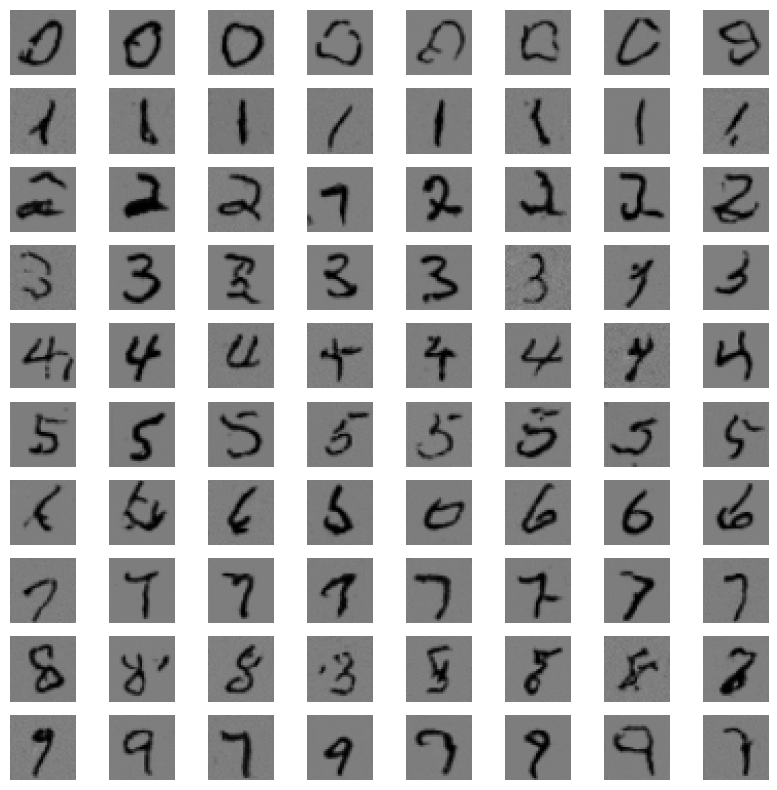

In [117]:
fig, axs = plt.subplots(10, 8, figsize=(10, 10))
for i in range(10):
    plot_images(sample[i*8:(i+1)*8], axs=axs[i])

Much, much better! Right? Digits are clearly recognizable, and the majority of them are decent examples of MNIST digits. Conditioned models for the win!

It doesn't get any better than that... or does it?

## Going Latent

Denoising small 32x32-pixel images already takes a little while, after all, it requires predicting an array of 1024 values for noise, one for each pixel. As images grow larger, it only gets worse.

If only there was a way to more succintly represent images... does anything come to mind?

Embeddings to the rescue! An embedding IS a compressed representation of its input, which is said to live in the latent space. 

Here'a crazy idea: what if we add noise to the compressed representation instead? Then, the model needs to learn how to predict fewer values for noise, since the denoising process will also happend in the latent space. Instead of 1024 pixels/dimensions, we could run the diffusion process in, say, 64 dimensions instead?

That's all really cool, but no one is actually interested in viewing denoised representations in latent space. People want to see REAL images, right? We need a way to decode the latent space back into the regular, human-friendly, pixel space.

We can use autoencoders for that, and that's the fourth and final component of the stable diffusion pipeline we introduced in the beginning.

P.S.: Another compressed representation can be found using Principal Component Analysis (PCA) - hold this thought, it will be useful soon.

### VAE

A variational autoencoder (VAE) is a special kind of autoencoder that allows sampling from the latent space, so the autoencoder model actually learns a distribution of values in latent space.

The diagram below illustrates its architecture. An image (x) comes in, it is encoded into its representation in the latent space, and the decoder learns how to produce a reconstructed image (x~) from a sample drawn from a Gaussian distribution.

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/vae_diagram_reparam.png?raw=true)

We're not going into the details here, but if you're interested in learning about the ins and outs of autoencoders, I wrote two extensive posts about them: [Understanding AutoEncoders with an example: A Step-By-Step Tutorial - Part I: Vanilla AutoEncoders](https://towardsdatascience.com/understanding-autoencoders-with-an-example-a-step-by-step-tutorial-693c3a4e9836) and [Understanding AutoEncoders with an Example: A Step-by-Step Tutorial - Part II: Variational AutoEncoders](https://towardsdatascience.com/understanding-autoencoders-with-an-example-a-step-by-step-tutorial-a79d2ea2945e).

We cannot easily replicate stable diffusion in a timely fashion, but we can stand on the shoulders of giants like Will Kurt, who wrote a brilliant blog post called "Linear Diffusion".

### Linear Diffusion

This section is an adaptation of Will Kurt's [Linear Diffusion: Building a Diffusion Model from linear Components](https://www.countbayesie.com/blog/2023/4/21/linear-diffusion) blog post. The original code for his linear diffusion can be found at https://github.com/willkurt/linear-diffusion.

The figure below, from the Will's post, is a funny depiction of the substitutions he made to the original pipeline:
- PCA replaces VAE, so encoding and decoding are performed using principal components;
- OHE (one-hot encoding) replaces CLIP, so text encoding is performed by mapping the class/label (the number represented by the handwritten digit) to its OHE vector;
- Linear regression replaces UNet, and conditioning is achieved by using interaction terms in the regression instead of stacking embedding "channels" in the input images.

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/cb_linear-diffusion-arch.png?raw=true)
Source: Will Kurt's [Linear Diffusion: Building a Diffusion Model from linear Components](https://www.countbayesie.com/blog/2023/4/21/linear-diffusion)

Will's implementation is based on Scikit-Learn, though, and I started adapting it to PyTorch for the purpose of integrating it into this material. There was a small issue, though: in Scikit-Learn, both PCA and regression are fitted on the whole training set. It's trivial to fit a regression using mini-batches in PyTorch, that's literally PyTorch 101 (you can check it here: https://github.com/dvgodoy/PyTorch101_ODSC_Europe_2022).

But, what about PCA? Running it on the whole training set at once kinda defeats the purpose of mini-batching, right? I couldn't find a "batched PCA" for PyTorch, so I wrote my own :-)

### Image Encoding with PCA

We're not going into the implementation details of batched PCA, but the general idea goes like this: the class draws from PyTorch's batch normalization class, which keeps track of running statistics during training and applies them to normalize the batches during evaluation. 

For batched PCA, we need to keep track of a running mean, and a running covariance matrix. By taking the covariance matrix for each mini-batch, and averaging them as more and more mini-batches are used for training, we'll approximate the covariance matrix of the whole training set.

Then, at evaluation time, we use the covariance matrix to get the principal components that are going to be used to transform/encoder (and later inverse transform/decode) the images.

In [118]:
from torch.linalg import svd

class BatchedPCA(nn.Module):
    def __init__(self, num_features, num_components=1, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.num_features = num_features
        self.num_components = num_components
        self.mean = None
        self.V = None
        self.components = None
        
        self.register_buffer('running_mean', torch.zeros(num_features, **factory_kwargs))
        self.register_buffer('running_cov', torch.zeros((num_features, num_features), **factory_kwargs))
        self.register_buffer('num_batches_tracked',
                             torch.tensor(0, dtype=torch.long, **{k: v for k, v in factory_kwargs.items() if k != 'dtype'}))
        
    @staticmethod
    def _C(x):
        return x.T @ x / x.shape[0]
    
    def _calc_components(self):
        cov = self.running_cov / self.num_batches_tracked
        self.V, eigenvalues, VT = svd(cov)
        self.components = self.V[:, :self.num_components]
    
    def forward(self, x, transform=True):
        if self.training:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked.add_(1)
            batch_mean = x.mean(dim=0)
            self.running_mean += batch_mean
            self.running_cov += self._C(x-batch_mean)        
            self.mean = self.running_mean / self.num_batches_tracked
    
        if (self.training and transform) or ((not self.training) and (self.components is None)):
            self._calc_components()
        
        if transform:
            proj = (x-self.mean) @ self.components
            return proj
        
    def transform(self, x):
        if self.components is None:
            self._calc_components()
        proj = (x-self.mean) @ self.components
        return proj        
    
    def inverse_transform(self, proj):
        if self.components is None:
            self._calc_components()
        reconst = proj @ self.components.T + self.mean
        return reconst
    
    def encode(self, x):
        return self.transform(x)
    
    def decode(self, proj):
        return self.inverse_transform(proj)

Let's reload our MNIST data one more time:

In [119]:
composed = Compose([ToTensor()])
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=composed)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Then, we loop over all mini-batches to train our batched PCA model:

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_size = 28
latent_size = 8
pca = BatchedPCA(num_features=image_size*image_size, num_components=latent_size*latent_size)
pca.to(device)

for images, labels in train_dataloader:
    pca(images.view(-1, image_size**2).to(device), transform=False)
pca.eval()

BatchedPCA()

We could train the batched PCA together with the main model, linear regression, but we choose to train them separately to more closely follow the original implementation.

Let's see if our batched PCA is working well or not.

#### Original

The original images are 28x28 pixels as we already know:

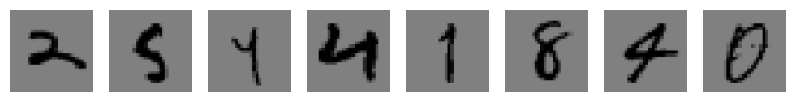

In [121]:
plot_images(images[:8])

#### Components

We chose a latent space of 8x8 components:

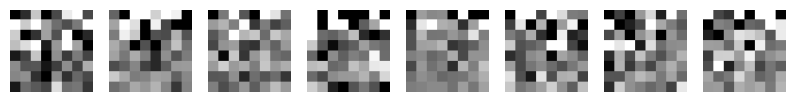

In [122]:
proj = pca.encode(images.view(-1, image_size**2).to(device))
plot_images(proj.cpu().view(proj.shape[0], latent_size, latent_size)[:8])

#### Reconstruction

If we use the components to reconstruct the images, we get the following:

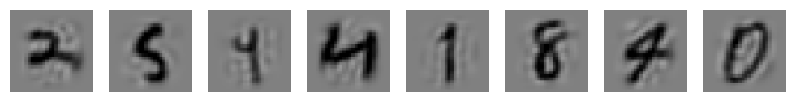

In [123]:
decoded = pca.decode(proj).cpu().view(proj.shape[0], image_size, image_size)[:8]
plot_images(decoded)

Not bad, right? Instead of 784 values in pixel space, we're using only 64 values in latent space, and we have a working image encoder and decoder, thus replacing the VAE from the stable diffusion pipeline.

### Text Encoding with One-Hot

Instead of using CLIP for text encoding, we'll restrict our vocabulary to "0", "1", "2", "3", "4", "5", "6", "7", "8" and "9", and settle for one-hot encoding.

In [124]:
text_encodings = F.one_hot(labels.squeeze(), num_classes=10)
text_encodings[:8]

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Conditioning with Interaction Terms

Linear regression and one-hot encoding are beautifully simple for such a complex task as a conditioned diffusion process, so we need to add interaction terms between image and text embeddings to make it work.

It is actually simple: we expand the OHE representation so each one of those 10 elements becomes the same shape as the image embeddings (64). Therefore, there will be 640 values in the expanded vector. The only non-zero values will be those correspoding to encoded label.

In [125]:
expanded = text_encodings.unsqueeze(-1).expand(labels.shape[0], 10, latent_size**2)
expanded.shape, expanded[0]

(torch.Size([32, 10, 64]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

The interaction terms vector is simply the multiplication of the expanded OHE vector, and the (unsqueezed) image embeddings:

In [126]:
unsqueezed = proj.unsqueeze(1)
unsqueezed.shape, unsqueezed[0]

(torch.Size([32, 1, 64]),
 tensor([[ 1.0747,  0.6624, -0.5572,  2.5950,  0.4275, -0.8365, -1.2745,  0.4431,
          -1.7802, -0.5854, -1.7059, -0.2822,  0.1450,  0.3947,  0.0559, -1.7934,
          -0.6065,  1.3065,  0.6074, -0.2562,  0.3681, -2.2877,  1.1929,  0.6919,
          -0.4843, -0.7327, -1.5014,  0.7790, -0.1846, -1.1377, -0.2780,  1.1401,
           0.8021,  0.4773, -0.5417,  1.1884, -0.1228,  0.5405,  0.0384,  0.4734,
          -0.0968,  0.3431,  0.3258,  0.8427,  0.5195, -0.1081,  0.4903, -0.3516,
          -0.0472, -0.1243,  0.6174,  1.1645, -0.1009,  0.6113,  0.1950,  0.4302,
           0.8182,  0.1569,  0.3018,  0.4518, -0.7311,  0.1336,  0.0817,  0.5835]],
        device='cuda:0'))

In [128]:
interactions = expanded.to(device) * unsqueezed
interactions[0]

tensor([[ 0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
         -0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
         -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
         -0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
         -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000, 

Next, we reshape it to two dimensions, so it can be concatenated to the others:

In [129]:
interactions.view(-1, 10*latent_size**2).shape

torch.Size([32, 640])

Then, all three, image embeddings, interaction terms, and text embeddings, are concatenated together to make up the input vector to the linear regression model, as depicted in the figure below:

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/cb_Linear+Diffusion+Images_interactions.png?raw=true)
Source: Will Kurt's [Linear Diffusion: Building a Diffusion Model from linear Components](https://www.countbayesie.com/blog/2023/4/21/linear-diffusion)

### Model

The model itself is quite simple, actually: it has only one layer, a linear layer. The `forward()` method takes the image embeddings (from PCA) and labels and:
- encodes the labels using OHE;
- concatenates them to the interaction terms, as described above;
- feeds it to the linear layer.

This is enough to train the model.

This image, from Will's post, illustrates the process very well:

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/cb_Linear+Diffusion+Images.png?raw=true)
Source: Will Kurt's [Linear Diffusion: Building a Diffusion Model from linear Components](https://www.countbayesie.com/blog/2023/4/21/linear-diffusion)

But we still need a `generate()` method that takes noisy samples, labels for conditioning, and a callable decode function (optional). It uses the model itself to: 
- predict noise in latent space;
- subtract the predicted noise from the noisy samples to get predicted denoised latent space;
- optionally, call the decoder function to transform latent space back into pixel space.

This other image from Will's post illustrates the generation process:

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/cb_Linear+Diffusion+Images_pred.png?raw=true)
Source: Will Kurt's [Linear Diffusion: Building a Diffusion Model from linear Components](https://www.countbayesie.com/blog/2023/4/21/linear-diffusion)

In [130]:
class LinearDiffusion(nn.Module):
    def __init__(self, image_size=28, latent_size=4, num_classes=10):
        super().__init__()
        self.image_size = image_size
        self.latent_size = latent_size
        self.num_classes = num_classes
        
        # 1. num_classes from length of OHE vector
        # 2. (num_classes + 1) from interaction terms and the image encoding itself,
        #    each one being latent_size**2 long
        # 3. the output is the predicted noise in latent space
        self.linear = nn.Linear(num_classes + (num_classes + 1) * latent_size**2 , latent_size**2)
        
    def _encode_text(self, labels):
        text_encodings = F.one_hot(labels.squeeze(), num_classes=self.num_classes)
        return text_encodings
                
    def forward(self, image_encoding, labels):
        assert image_encoding.shape[0] == labels.shape[0]
        # encodes text using OHE
        with torch.no_grad():
            text_encodings = self._encode_text(labels)

        # computes interaction terms
        interaction_terms = (text_encodings
                             .unsqueeze(-1)
                             .expand(labels.shape[0], 
                                     self.num_classes, 
                                     self.latent_size**2) * image_encoding.unsqueeze(1)).view(-1, self.num_classes*self.latent_size**2)
        # concatenates encodings/embeddings and interaction terms
        x = torch.cat([image_encoding, text_encodings, interaction_terms], axis=1)
        # use concatenation as inputs to linear layer
        x = self.linear(x)
        return x
    
    def generate(self, samples, labels, decode_fn):
        # predicts total noise
        pred_noise = self(samples, labels).detach()
        # removes noise from samples to get predicted denoised latent space
        pred_x0 = samples - pred_noise
        if callable(decode_fn):
            # returns decoded pixel space
            images = decode_fn(pred_x0).view(-1, 1, image_size, image_size)
        else:
            # returns predicted latent space
            images = pred_x0.view(-1, 1, latent_size, latent_size)
        return images

### Training Loop

The training loop is roughly the same as always, but we use PCA to encode images into latent space and manually add noise to the latent representations at once (we don't use a scheduler here).

In [131]:
model = LinearDiffusion(image_size=28, latent_size=8, num_classes=10)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()

In [132]:
losses = []

for epoch in tqdm(range(10)):
    for step, batch in enumerate(train_dataloader):
        # Step 1: Fetch Clean Images
        clean_images = batch[0].to(device)
        clean_labels = batch[1].to(device)
        bs = clean_images.shape[0]
        
        with torch.no_grad():
            latent = pca.encode(clean_images.view(bs, -1))
        
        # Step 2: Generate (Full) Noise
        noise = torch.randn_like(latent).to(device)

        # Step 4: Add Noise to Clean Images
        noisy_latent = latent + noise

        # Step 5: Predict (Full) Noise from Noisy Images
        noise_pred = model(noisy_latent, clean_labels)

        # Step 6: Compute Loss
        loss = loss_fn(noise_pred, noise)

        # Regular PyTorch training loop stuff
        loss.backward(loss)
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

 50%|█████     | 5/10 [00:51<00:51, 10.22s/it]

Epoch:5, loss: 0.23018382137009838


100%|██████████| 10/10 [01:43<00:00, 10.33s/it]

Epoch:10, loss: 0.22557087906642254


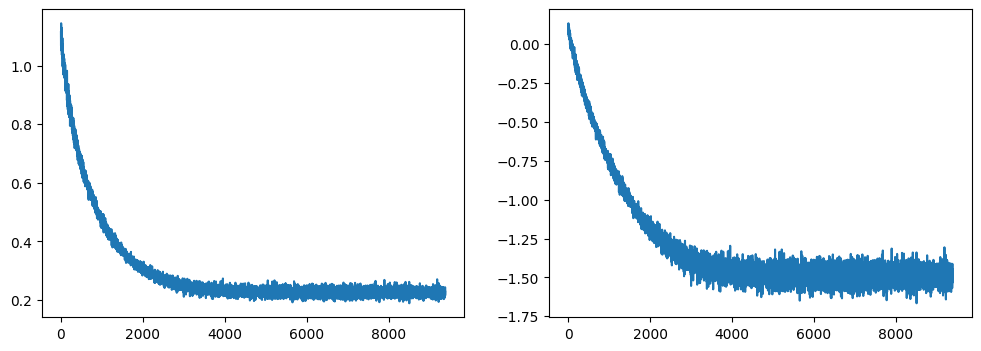

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

### Generating Images

Let's generate some noisy latent space and some labels, and denoise them using our Linear Diffusion model:

In [134]:
samples = torch.randn(10, latent_size*latent_size).to(device)
labels = torch.arange(10).to(device)
images = model.generate(samples, labels, decode_fn=pca.decode)

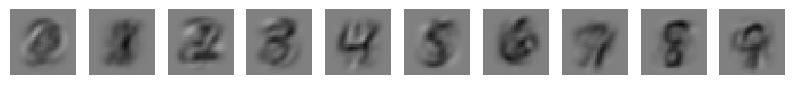

In [135]:
plot_images(images, n=10)

Not too shabby for a linear model, PCA, and OHE, right?

That's a wrap, we've gone through several diffusion-related topics! But that's only the beginning... there is plenty of other techniques and methods, and it is virtually impossible to keep track of every new development.

Hopefully, you're now better equipped to venture into this brave new world of image generation :-)

Thank you!

If you want to dive deeper into Stable Diffusion, besides the resources already used here, I suggest you take a look at:
- [The Illustrated Stable Diffusion](https://jalammar.github.io/illustrated-stable-diffusion/) by Jay Alammar
- [From Deep Learning Foundations to Stable Diffusion](https://www.fast.ai/posts/2023-04-04-part2-2023.html) by fast.ai

## Bonus

Generating images out of pure noise is incredible, but it is only the tip of the iceberg. Here I included a few other amazing uses of the stable diffusion pipeline.

### Image2Image

As the name says, it starts with an image, and turns it into another. You can think of it as giving the model a helping hand, so it doesn't have to start from pure noise.

The example below comes from a [fast.ai notebook on diffusion](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb): it takes a rough sketch of a wolf howling at the moon as starting point, and turns it into a really nice image.

In [136]:
from diffusers import StableDiffusionImg2ImgPipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)
pipe.to(device)

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

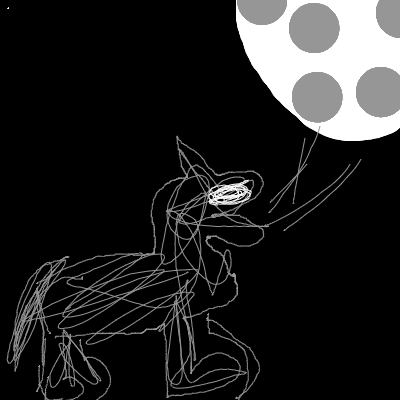

In [137]:
import shutil
import requests

url = 'https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png'
response = requests.get(url, stream=True)
with open('img.png', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)

from PIL import Image
init_image = Image.open('img.png').convert("RGB")
init_image

In [138]:
torch.manual_seed(1000)
prompt = "Wolf howling at the moon, photorealistic 4K"
images = pipe(prompt=prompt, num_images_per_prompt=3, image=init_image, strength=0.8, num_inference_steps=50).images

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:559: FutureWarning: You have passed 3 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/40 [00:00<?, ?it/s]

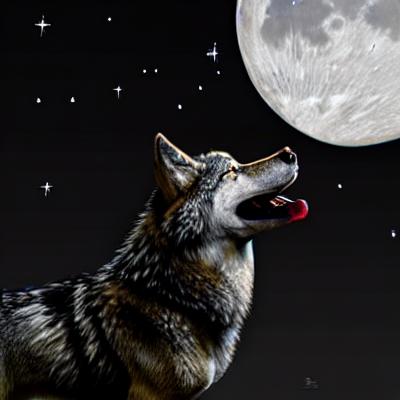

In [140]:
init_image = images[2]
init_image

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:559: FutureWarning: You have passed 3 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/70 [00:00<?, ?it/s]

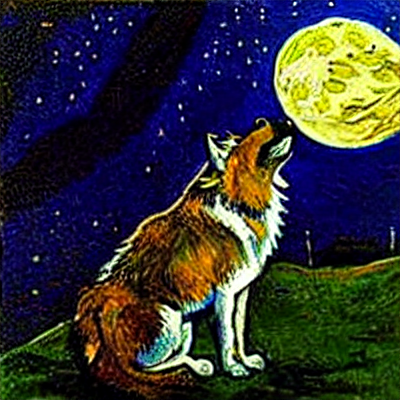

In [141]:
torch.manual_seed(1000)
prompt = "Oil painting of wolf howling at the moon by Van Gogh"
new_images = pipe(prompt=prompt, num_images_per_prompt=3, image=init_image, strength=1, num_inference_steps=70).images
new_images[2]

### Textual Inversion

Textual inversion, proposed in the [An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion](https://textual-inversion.github.io/) paper and [repo](https://github.com/rinongal/textual_inversion), is a technique that allows you to consistently place yourself, or anything you want, in the generated images. How would you condition a model to generate images of you? Unless you're famous enough to be part of the training set used to train a CLIP model, chances are you're unknown to CLIP.

But, even if you don't want to place yourself, but your dog, the diffusion process will generate "a" dog, not "your" dog. It may get the breed correctly, but it will still be a generic dog.

You see, the problem is that you, and your dog, are unknown to CLIP. Textual inversion fixes that! How? It takes a specific, rarely used token (for whatever reason "sks" is a popular choice), and overfits it to a selection of images of yourself, or your dog. That way, CLIP gets to know you, and you can start calling yourself "sks" for the purpose of image generation.

You can also check HuggingFace's [textual inversion fine-tuning example](https://github.com/huggingface/diffusers/tree/main/examples/textual_inversion), but the example below comes from a [fast.ai notebook on diffusion](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb):

In [142]:
pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16) 
pipe = pipe.to(device)

embeds_url = "https://huggingface.co/sd-concepts-library/indian-watercolor-portraits/resolve/main/learned_embeds.bin"
response = requests.get(embeds_url, stream=True)
with open('learned_embeds.bin', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)

embeds_dict = torch.load('learned_embeds.bin', map_location=device)

text_encoder/model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [143]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
new_token, embeds = next(iter(embeds_dict.items()))
embeds = embeds.to(text_encoder.dtype)
new_token

'<watercolor-portrait>'

In [144]:
assert tokenizer.add_tokens(new_token) == 1, "The token already exists!"

In [145]:
text_encoder.resize_token_embeddings(len(tokenizer))
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
text_encoder.get_input_embeddings().weight.data[new_token_id] = embeds

  0%|          | 0/50 [00:00<?, ?it/s]

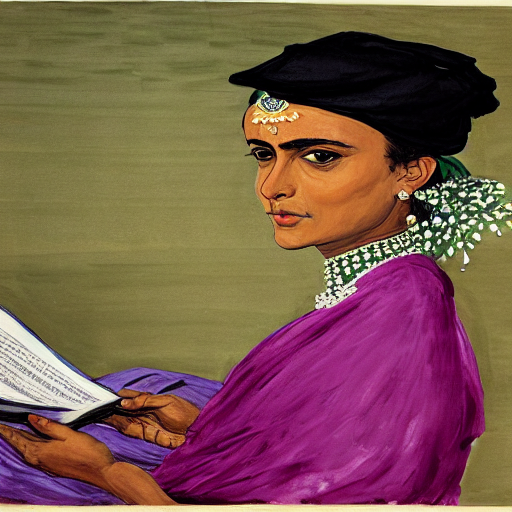

In [146]:
torch.manual_seed(1000)
image = pipe("Woman reading in the style of <watercolor-portrait>").images[0]
image

### DreamBooth

DreamBooth is named after the idea of having a photobooth where you enter your dreams, placing yourself (or your dog) anywhere you want using image generation. It is the evolution of the textual inversion idea, but fine-tuning the whole model instead of only the textual embeddings. Before, you made CLIP know you, now, you'll make the whole stable diffusion pipeline aware of your existence :-)

Check the official [DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation](https://dreambooth.github.io/) for more details, and HuggingFace's [notebook from the Diffusers course](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/hackathon/dreambooth.ipynb) for a working example.

## Final Thoughts

I hope this tutorial helped you develop intuition about the inner workings of diffusion models, and how you can train, guide, and condition them to generate cool and interesting images :-)

If you have any thoughts, comments or questions, please contact me on [LinkedIn](https://br.linkedin.com/in/dvgodoy) or [Twitter](https://twitter.com/dvgodoy).

<h1><center>THANK YOU!</center></h1>

<h2><center>
    If you liked my talk and are interested in learning more about PyTorch, ccheck my book's official website:
<br>
<br>
<a href="https://pytorchstepbystep.com">
<p align="center">
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2022/main/images/book_cover.png" width="60%">
</p>
<br>
    https://pytorchstepbystep.com
</a>
</center></h2>